<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/Fine_tune_and_Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from tensorflow.keras.preprocessing import image
import numpy as np
import scipy
from scipy.io import loadmat
import glob
import h5py
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import datasets, transforms

import numpy
from scipy.ndimage import gaussian_filter
from numpy.lib.stride_tricks import as_strided as ast
import numpy as np
import math

## Model 

In [3]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [4]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target

class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [5]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor

# ===============================img tranforms============================

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:# 随机生成0-1之间的浮点数 ，每次执行生成的不一样
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        # if self.padding > 0:
        #     img = ImageOps.expand(img, border=self.padding, fill=0)
        #     mask = ImageOps.expand(mask, border=self.padding, fill=0)
        #
        # assert img.size == mask.size
        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

## Loading Data

### SH_A and SH_B

In [6]:
def load_SH_trainData(part):
  img_train_list = os.listdir("/content/drive/MyDrive/Model_Test_Data/"+part+"/train_data/images") 
  img_list = []
  for img in img_train_list:
    if '.jpg' in img:
      img_list.append(img)

  sh_train_list_A = []
  for img_ in img_list:
    img_ = "/content/drive/MyDrive/Model_Test_Data/"+part+"/train_data/images/"+img_
    sh_train_list_A.append(img_)
  return sh_train_list_A

def load_SH_testData(part):
  img_test_list = os.listdir("/content/drive/MyDrive/Model_Test_Data/"+part+"/test_data/images")
  img_list = []
  for img in img_test_list:
    if '.jpg' in img:
      img_list.append(img)
  if part == "PartB":
    img_list.remove("IMG_239 (1).jpg")
  sh_test_list = []
  for img_ in img_list:
    img_ = "/content/drive/MyDrive/Model_Test_Data/"+part+"/test_data/images/"+img_
    sh_test_list.append(img_)
  return sh_test_list

#### UCF_CC_50

In [ ]:
def load_ucf_cc_50():
  path = img_test_list = os.listdir("/content/drive/MyDrive/Model_Test_Data/UCF_CC_50")
  img_list = []
  for img in path:
    if '.jpg' in img:
      img_list.append(img)
  ucf_cc_list = []
  for img_ in img_list:
    img_ = "/content/drive/MyDrive/Model_Test_Data/UCF_CC_50"+"/"+img_
    ucf_cc_list.append(img_)
  return ucf_cc_list

#### UCF_QNRF

In [24]:
def load_data_ucf_qnrf(img_path,train = True , part = None , h5_part = None):
    gt_path = img_path.replace('.jpg','.h5').replace(part+'/','ground-truth-h5-'+h5_part+'/')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target

class ListDataset_QNRF(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4 ,part= None, h5_part = None):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.part = part
        self.h5_part = h5_part
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data_ucf_qnrf(img_path,self.train , self.part , self.h5_part)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target


def get_tar_shot_loader_ucf_qnrf(train_part , batch_size = 1):
  tar_main_transform = Compose([
        RandomCrop(((576,768))),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])

  tar_shot_loader = torch.utils.data.DataLoader(ListDataset_QNRF(train_part,shuffle=True,
                                                                main_transform = tar_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                #transforms.Resize(480),
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=batch_size,
                                                                num_workers=2,
                                                                part = "Train",
                                                                h5_part = "train"),batch_size=batch_size)  
  
  return tar_shot_loader


def get_tar_test_loader_ucf_qnrf(test_part , batch_size = 1):
  test_loader = torch.utils.data.DataLoader(ListDataset_QNRF(test_part,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Resize(480),
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=batch_size,
                                                                num_workers=2,
                                                                part = "Test",
                                                                h5_part = "test"),batch_size=batch_size) 
  return test_loader




def load_ucf_qnrf_test_data(part):
  img_path_list = os.listdir("/content/drive/MyDrive/Model_Test_Data/UCF-QNRF/UCF-QNRF_ECCV18/"+part+"/")
  imglist =[]
  for img in img_path_list:
    if '.jpg' in img:
      #imglist.append(img)
      img_path ="/content/drive/MyDrive/Model_Test_Data/UCF-QNRF/UCF-QNRF_ECCV18/"+part+"/"+ img
      imglist.append(img_path)

  return imglist

#### SH_A and B

In [7]:
def get_tar_shot_loader(train_part , batch_size = 1):
  tar_main_transform = Compose([
        RandomCrop(((576,768))),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])

  tar_shot_loader = torch.utils.data.DataLoader(ListDataset(train_part,shuffle=True,
                                                                main_transform = tar_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=batch_size,
                                                                num_workers=2),batch_size=batch_size)  
  
  return tar_shot_loader


def get_tar_test_loader(test_part , batch_size = 1):
  test_loader = torch.utils.data.DataLoader(ListDataset(test_part,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=batch_size,
                                                                num_workers=2),batch_size=batch_size) 
  return test_loader

In [8]:
model_path = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withbackend_3.pth'

tar_model = TestNet().cuda()
# load the trained model
tar_model.load_state_dict(torch.load(model_path))
print('successfully load model from', model_path)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

successfully load model from /content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withbackend_3.pth


In [9]:
lr = 1e-5
tar_optimizer =  torch.optim.Adam(tar_model.parameters(), lr = lr, weight_decay=1e-4)


In [10]:
def block_view(A, block=(3, 3)):
    """Provide a 2D block view to 2D array. No error checking made.
    Therefore meaningful (as implemented) only for blocks strictly
    compatible with the shape of A."""
    # simple shape and strides computations may seem at first strange
    # unless one is able to recognize the 'tuple additions' involved ;-)
    shape = (int(A.shape[0]/ block[0]), int(A.shape[1]/ block[1]))+ block
    strides = (block[0]* A.strides[0], block[1]* A.strides[1])+ A.strides
    return ast(A, shape= shape, strides= strides)

def get_ssim(img1, img2, C1=0.01**2, C2=0.03**2):

    bimg1 = block_view(img1, (11,11))
    bimg2 = block_view(img2, (11,11))
    s1  = numpy.sum(bimg1, (-1, -2))
    s2  = numpy.sum(bimg2, (-1, -2))
    ss  = numpy.sum(bimg1*bimg1, (-1, -2)) + numpy.sum(bimg2*bimg2, (-1, -2))
    s12 = numpy.sum(bimg1*bimg2, (-1, -2))

    vari = ss - s1*s1 - s2*s2
    covar = s12 - s1*s2

    ssim_map =  (2*s1*s2 + C1) * (2*covar + C2) / ((s1*s1 + s2*s2 + C1) * (vari + C2))

    return numpy.mean(ssim_map)

def get_psnr(im_true, im_test):
    pixel_max = np.max(im_true)
    if pixel_max != 0:
        im_true = im_true/pixel_max*255
    pixel_max = np.max(im_test)
    if pixel_max != 0:
        im_test = im_test/pixel_max*255

    return compare_psnr(im_true,im_test,data_range=255)

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [12]:
sh_train_list_partA = load_SH_trainData("PartA")
sh_train_list_partB = load_SH_trainData("PartB")
print(len(sh_train_list_partA))
print(len(sh_train_list_partB))


sh_test_list_partA = load_SH_testData("PartA")
sh_test_list_partB = load_SH_testData("PartB")
print(len(sh_test_list_partA))
print(len(sh_test_list_partB))

tar_shot_loader = get_tar_shot_loader(sh_train_list_partB)
test_loader = get_tar_test_loader(sh_test_list_partB)

300
400
182
316


In [ ]:
test_ucf_cc_50 = (load_ucf_cc_50())
test_loader_ucf = get_tar_test_loader(test_ucf_cc_50)

In [25]:
tar_shot_loader_ucf_qnrf  = get_tar_shot_loader_ucf_qnrf(load_ucf_qnrf_test_data("Train"))
test_loader_ucf_qnrf = get_tar_test_loader_ucf_qnrf(load_ucf_qnrf_test_data("Test"))

## check no adapt result

In [13]:
from torch.autograd import Variable
from skimage.measure import compare_psnr, compare_ssim

In [32]:
  with torch.no_grad():
    tar_model.eval()
    test_mae = AverageMeter()
    test_mse = AverageMeter()
    ssims = AverageMeter()
    psnrs = AverageMeter()
    for j, (img_test, target_test) in enumerate(test_loader_ucf_qnrf):
        img_test = img_test.cuda()
        img_test = Variable(img_test)   
        output_test = tar_model(img_test)
        
        sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae, test_mse)#,ssims , psnrs)
        if j % 40== 0:
          print('s_gt={:.1f} s_pre={:.1f} '.format(sou_label_cnt_test,sou_pred_cnt_test))
  print('test_mae_tar', float(test_mae.avg))
  print('test_mse_tar', float(np.sqrt(test_mse.avg)))
  print('test_ssims_tar', float(ssims.avg))
  print('test_psnrs_tar', float(psnrs.avg))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


s_gt=1750.6 s_pre=764.2 
s_gt=2736.2 s_pre=853.7 


KeyboardInterrupt: ignored

# fine tune and test

In [14]:
def get_pr_value(value):
  pr_list = []
  for i in range(1 , 10):
    pr_val = value*(i*10)//100
    pr_list.append(pr_val)
  return pr_list

persntage_list = get_pr_value(len(sh_train_list_partB))
persntage_list

[40, 80, 120, 160, 200, 240, 280, 320, 360]

In [15]:
mae_list =[]
mse_list = []
ssim_list= []
psnr_list = []

In [ ]:
test_mae_ = AverageMeter()
test_mse_ = AverageMeter()

In [ ]:
for pr_val in persntage_list:
  test_best_mae = 18.28
  test_best_mse = 25.87
  best_ssim = 0.7998
  best_psnr = 26.48
  for epoch in range(1,51):
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (shot_img, shot_label) in enumerate(tar_shot_loader, 1):
      if i <= pr_val:
        shot_img = shot_img.cuda()
        shot_label = shot_label.cuda()
        shot_pred = tar_model(shot_img)

        loss = F.mse_loss(shot_pred.squeeze(), shot_label.squeeze())
        tar_optimizer.zero_grad()
        loss.backward()
        tar_optimizer.step()

        pred_cnt, label_cnt = mae_mse_update(shot_pred, shot_label , train_mae , train_mse)
      else:
        break
    print('train_mae_tar', float(train_mae.avg), epoch)
    print('train_mse_tar', float(np.sqrt(train_mse.avg)), epoch)
    print("testing...................")  
    with torch.no_grad():
      tar_model.eval()
      test_mae_ = AverageMeter()
      test_mse_ = AverageMeter()
      ssims_ = AverageMeter()
      psnrs_ = AverageMeter()
      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output_test = tar_model(img_test)

          sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae_, test_mse_,ssims_ ,psnrs_ )
          #if j % 100== 0:
            #print('Epoch {}, s_gt={:.1f} s_pre={:.1f} '.format(epoch, sou_label_cnt_test,sou_pred_cnt_test))
    print('test_mae_tar', float(test_mae_.avg), epoch)
    print('test_mse_tar', float(np.sqrt(test_mse_.avg)), epoch)
    print('test_ssims_tar', float(ssims_.avg))
    print('test_psnrs_tar', float(psnrs_.avg))
    if test_mae_.avg<test_best_mae:
      test_best_mae = test_mae_.avg
      print("Best test MAE", test_best_mae)
      #MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/currently_best_TestNetGCC_whole_data_withbackend_finetuned_SH_A_best_3.pth'
      #torch.save(tar_model.state_dict(), MODEL_SAVE_PATH)
    if np.sqrt(test_mse_.avg)<test_best_mse:
      test_best_mse = np.sqrt(test_mse_.avg)
      print("Best test MSE", test_best_mse)
    if ssims_.avg > best_ssim and ssims_.avg < 1:
      best_ssim = ssims_.avg
      print("Best SSIM",best_ssim)
      #MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/currently_best_TestNetGCC_whole_data_withbackend_finetuned_SH_A_best_ssim_3.pth'
      #torch.save(tar_model.state_dict(), MODEL_SAVE_PATH)
    if psnrs_.avg > best_psnr:
      best_psnr = psnrs_.avg
      print("Best PSNR", best_psnr)
  mae_list.append(test_best_mae)
  mse_list.append(test_best_mse)
  ssim_list.append(best_ssim)
  psnr_list.append(best_psnr)
  print("one persantage finished!!")
  print(mae_list)
  print(mse_list)
  print(ssim_list)
  print(psnr_list)

    #MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/currently_best_TestNetGCC_whole_data_withbackend_finetuned_SH_A_best_2.pth'
    #torch.save(tar_model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


train_mae_tar 25.63064811229706 1
train_mse_tar 38.87983367574181 1
testing...................


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


test_mae_tar 22.464108690430848 1
test_mse_tar 32.05581534728668 1
test_ssims_tar 0.7357769755564064
test_psnrs_tar 27.90489160648361
Best PSNR 27.90489160648361
train_mae_tar 19.41587574481964 2
train_mse_tar 26.071387007715412 2
testing...................
test_mae_tar 44.00599781169167 2
test_mse_tar 68.71134273655561 2
test_ssims_tar 1.0951896722463867
test_psnrs_tar 26.986795788544878
train_mae_tar 13.506547236442566 3
train_mse_tar 16.94781502726383 3
testing...................
test_mae_tar 24.474966682965242 3
test_mse_tar 36.84990226385356 3
test_ssims_tar 0.9280502789807094
test_psnrs_tar 27.27258481357142
Best SSIM 0.9280502789807094
train_mae_tar 11.049556577205658 4
train_mse_tar 15.140662163984787 4
testing...................
test_mae_tar 30.16543759575373 4
test_mse_tar 43.38458689917436 4
test_ssims_tar 0.845412949406648
test_psnrs_tar 28.68903855744304
Best PSNR 28.68903855744304
train_mae_tar 33.11666994094848 5
train_mse_tar 48.80754941817565 5
testing.................

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


test_mae_tar 29.892112719861768 38
test_mse_tar 41.172196100047316 38
test_ssims_tar inf
test_psnrs_tar 29.340447517372446
train_mae_tar 19.87480531136195 39
train_mse_tar 28.012111704738956 39
testing...................
test_mae_tar 18.324181336390822 39
test_mse_tar 30.16972120132174 39
test_ssims_tar 0.8604863492117699
test_psnrs_tar 30.198911104318956
train_mae_tar 12.133421385288239 40
train_mse_tar 20.00519574196697 40
testing...................
test_mae_tar 50.32316447209708 40
test_mse_tar 79.13862701570316 40
test_ssims_tar 0.8729992958516637
test_psnrs_tar 26.80859923928625
train_mae_tar 19.5687597155571 41
train_mse_tar 27.10043837462556 41
testing...................
test_mae_tar 102.43380480778369 41
test_mse_tar 117.56661596943181 41
test_ssims_tar 0.7994023572323443
test_psnrs_tar 29.845263805267834
train_mae_tar 16.301275459925332 42
train_mse_tar 24.984541346619302 42
testing...................
test_mae_tar 19.438285984570467 42
test_mse_tar 28.333457384223006 42
test_s

In [ ]:
print(test_best_mae)

92.33


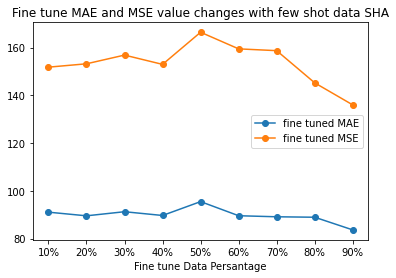

In [ ]:
import matplotlib.pyplot as plt

x1 = ["10%","20%","30%","40%","50%","60%","70%","80%","90%" ]
y1 = [91.08, 89.55, 91.23, 89.69, 95.50, 89.59, 89.15, 88.95, 83.64]
y2 = [151.81, 153.22, 156.87, 152.98, 166.45, 159.49, 158.73, 145.24, 136.00]

plt.plot(x1, y1, marker="o")
plt.plot(x1, y2, marker="o")
plt.title("Fine tune MAE and MSE value changes with few shot data SHA")
plt.xlabel("Fine tune Data Persantage")
plt.legend(["fine tuned MAE", "fine tuned MSE"])
